# 3.1 Comparing to Measurements - Timezone and Time Period alignment

In this example, our measurement data is:
  - 5 minute averages
  - timestamps labelled with the period start
  - unknown timezone
  
which we want to compare to 30 minute Solcast data.

(N.B. if you do not know whether your measurement data is labelled with the start or end of the period, the best approach is to try assuming either way and seeing which gives you the best result)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Loading Data

In [2]:
# retrieve relevant Solcast data
from solcast import historic

# NOTE: this will consume an API request!
resp = historic.radiation_and_weather(
    latitude=34.2547, longitude=-89.8729,
    # we get a buffer for this example, because we don't
    # know the timezone of our measurement data
    start="2021-05-14 00:00", end="2021-05-18 00:00",
    output_parameters=["ghi"],
    period="PT30M",
)
solcast = resp.to_pandas()
# convert to tz-naive since we will be comparing 
# to measurements of unknown time zone.
solcast.index = solcast.index.tz_convert(None)  

solcast.head()

,ghi
period_end,
2021-05-14 00:30:00,63
2021-05-14 01:00:00,8
2021-05-14 01:30:00,0
2021-05-14 02:00:00,0
2021-05-14 02:30:00,0


,ghi
period_start,
2021-05-15 02:00:00,0.0
2021-05-15 02:05:00,0.0
2021-05-15 02:10:00,0.0
2021-05-15 02:15:00,0.0
2021-05-15 02:20:00,0.0


<Axes: xlabel='period_start'>

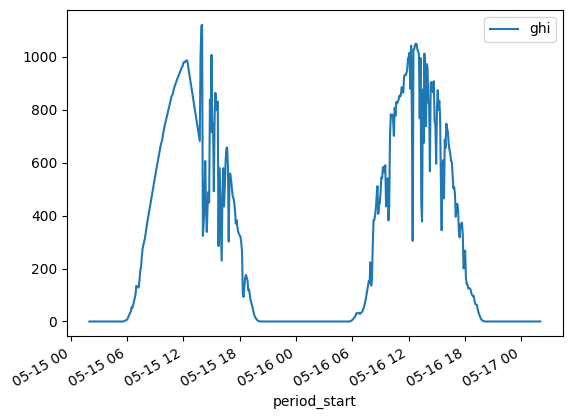

In [3]:
# load raw measurements
meas_raw = pd.read_csv("./data/3.1_sample_measurements.csv", index_col=0, parse_dates=True)

# clean up any clearly wrong values 
meas_raw.loc[meas_raw["ghi"]<0, "ghi"] = 0

display(meas_raw.head())
meas_raw.plot()

## Resampling Measurement Data

Here we resample measurement data to 30 minute averages, labelled with period_end

In [4]:
# In this example we are targeting 30 minute periods
target_minutes = 30
# we have 5 minute measurement data, so we expect
# 6 measurements per 30 minute period, allowing one to be missing:
minimum_measurements_per_period = 5
# if the raw_measurements are averaged by:
#   - period start, then closed="left"
#   - period end, then closed="right"
#   - instantaneous, then closed="right" 
#     (but you should ensure you have at least one-minute data!)
# for conversion to period_end
closed = "left"              

# label="right" to make the timestamp timestamps labelled with the period end
# (label="left" would make the timestamps labelled with the period start)
groupby = meas_raw.resample(f"{target_minutes}T", label="right", closed=closed)
meas_resampled = groupby.mean()
measurements_count = groupby.count()
meas_resampled = meas_resampled.where(measurements_count >= minimum_measurements_per_period)
meas_resampled.index.name = "period_end"


Plotting up the results

- some times have been dropped to due incomplete measurements
- the PT15M timeseries is shifted to the right - this is expected, because multiple PT5M timestamps go into a single resampled timestamp, e.g.

```
resampled PT15M period_end | raw measurements PT5M period_starts 
12:45                      | [12:30, 12:35, 12:40]
13:00                      | [12:45, 12:50, 12:55]
...
```

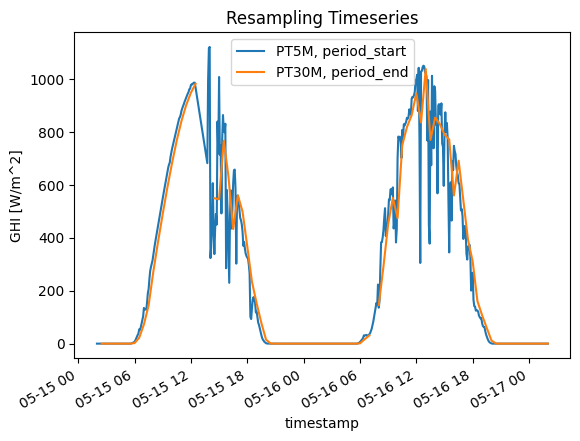

In [5]:
# plot up results
meas_raw["ghi"].plot(label="PT5M, period_start")
meas_resampled["ghi"].plot(label="PT30M, period_end")
plt.xlabel("timestamp")
plt.ylabel("GHI [W/m^2]")
plt.title("Resampling Timeseries")
plt.legend()
plt.show()

## Timezone Shifting Solcast Data

Here we detect the timezone of the measurements, and shift the Solcast Data to match this: 

Detected timezone shift: -5.0 hours


,ghi_solcast,ghi_meas
period_end,,
2021-05-15 02:30:00,0,0.0
2021-05-15 03:00:00,0,0.0
2021-05-15 03:30:00,0,0.0
2021-05-15 04:00:00,0,0.0
2021-05-15 04:30:00,0,0.0


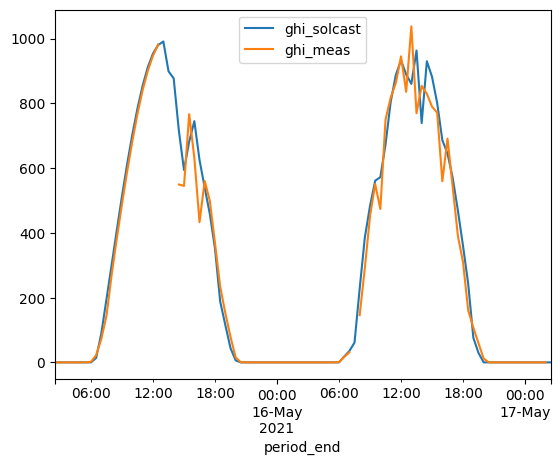

In [6]:
def detect_timezone_shift(ghi_to_be_shifted: pd.Series, target_ghi: pd.Series) -> float:
    """Computes the necessary timezone shift to best match the supplied ghi timeseries.
    
    Here we shift the timeseries by 15 min each time,
    and pick the shift that gives the lowest error.
    This works quite well because of the day/night signature
    in the timeseries, so even a moderate amount of corrupt
    data will generally not break this check.

    However, there are certaintly pathological corrupt measurements
    that would cause this timezone shift detection to fail - use with caution!
    
    """
    src = ghi_to_be_shifted.copy()
    errors = {}
    for shift in np.arange(-13, 13.25, 0.25):
        shifted = src.copy()
        shifted.index = shifted.index + pd.Timedelta(hours=shift)
        errors[shift] = (shifted - target_ghi).abs().mean()
    errors = pd.Series(errors)
    return errors.idxmin()


tz = detect_timezone_shift(solcast["ghi"], meas_resampled["ghi"])
print(f"Detected timezone shift: {tz} hours")

# create a combined Solcast + Measurements DataFrame
df = solcast.copy()
df.index = df.index + pd.Timedelta(hours=tz)
df = df.add_suffix("_solcast").join(meas_resampled.add_suffix("_meas"))
df = df.loc[meas_resampled.index]

df.plot()
display(df.head())
